In [74]:
import sys, os
import pathlib
import gc
# include parent directory in Python path.
sys.path.insert(1, os.path.join(sys.path[0], '..'))

import numpy as np
import pandas as pd

from sklearn.pipeline import Pipeline
from xgboost import XGBRegressor
from xgboost import plot_tree
from xgboost import plot_importance
import category_encoders as ce

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from utils import show_ram_usage, merge_train_structures, reduce_mem_usage, group_mean_log_mae
from models.linear import linear

In [2]:
show_ram_usage()

RAM usage: 0.11846923828125 GB


In [3]:
train = pd.read_csv('../dataset/train.csv')
dipole_moments = pd.read_csv('../dataset/dipole_moments.csv')
magnetic_shielding_tensors = pd.read_csv('../dataset/magnetic_shielding_tensors.csv')
potential_energy = pd.read_csv('../dataset/potential_energy.csv')
scalar_coupling_contributions = pd.read_csv('../dataset/scalar_coupling_contributions.csv')
structures = pd.read_csv('../dataset/structures.csv')

test = pd.read_csv('../dataset/test.csv')
submission = pd.read_csv('../dataset/sample_submission.csv')

In [4]:
show_ram_usage()

RAM usage: 1.0136871337890625 GB


# 1. Exploratory Data Analysis

## 1.1 Data Size and Columns

In [6]:
print("train shape {}, columns: {}".format(train.shape, train.columns.to_list()))
print("dipole shape {}, columns: {}".format(dipole_moments.shape, dipole_moments.columns.to_list()))
print("mst shape {}, columns: {}".format(magnetic_shielding_tensors.shape, magnetic_shielding_tensors.columns.to_list()))
print("pe shape {}, columns: {}".format(potential_energy.shape, potential_energy.columns.to_list()))
print("scc shape {}, columns: {}".format(scalar_coupling_contributions.shape, scalar_coupling_contributions.columns.to_list()))
print("structures shape {}, columns: {}".format(structures.shape, structures.columns.to_list()))

print("\n\ntest shape {}, test columns: {}".format(test.shape, test.columns.to_list()))

train shape (4658147, 6), columns: ['id', 'molecule_name', 'atom_index_0', 'atom_index_1', 'type', 'scalar_coupling_constant']
dipole shape (85003, 4), columns: ['molecule_name', 'X', 'Y', 'Z']
mst shape (1533537, 11), columns: ['molecule_name', 'atom_index', 'XX', 'YX', 'ZX', 'XY', 'YY', 'ZY', 'XZ', 'YZ', 'ZZ']
pe shape (85003, 2), columns: ['molecule_name', 'potential_energy']
scc shape (4658147, 8), columns: ['molecule_name', 'atom_index_0', 'atom_index_1', 'type', 'fc', 'sd', 'pso', 'dso']
structures shape (2358657, 6), columns: ['molecule_name', 'atom_index', 'atom', 'x', 'y', 'z']


test shape (2505542, 5), test columns: ['id', 'molecule_name', 'atom_index_0', 'atom_index_1', 'type']


It seems like `molecule_name` is the common feature across the datasets. `scalar_coupling_constant` is what we are trying to predict.

## 1.2 Check Data Split

In [7]:
if not (set(train.molecule_name) & set(test.molecule_name)):
    print("train and test contains completely different molecule_name")

train and test contains completely different molecule_name


In [8]:
if not ((set(train.molecule_name) - set(dipole_moments.molecule_name)) and
        (set(train.molecule_name) - set(magnetic_shielding_tensors.molecule_name)) and
        (set(train.molecule_name) - set(potential_energy.molecule_name)) and
        (set(train.molecule_name) - set(scalar_coupling_contributions.molecule_name)) and
        (set(train.molecule_name) - set(structures.molecule_name))):
    print("train, dipole_moments, magnetic_shielding_tensors, potential_energy, scalar_coupling_contributions, and structures have the same set of molecule_name")

train, dipole_moments, magnetic_shielding_tensors, potential_energy, scalar_coupling_contributions, and structures have the same set of molecule_name


`train` and `test` are splitted by `molecule_name`. We can find all `molecule_name` in `dipole_moments`, `magnetic_sheilding_tensors`, `potential_energy`, `scalar_coupling_contributions`, and `structures`. Since `train` and `scalar_coupling_contributions` are of the same size, let's check if their `molecule_name` are the same.

In [9]:
if (train['molecule_name'].equals(scalar_coupling_contributions['molecule_name']) and
    train['atom_index_0'].equals(scalar_coupling_contributions['atom_index_0']) and
    train['atom_index_1'].equals(scalar_coupling_contributions['atom_index_1'])):
    print('Train and scalar_coupling_contributions has the same molecule_name, atom_index_0, atom_index_1.')

Train and scalar_coupling_contributions has the same molecule_name, atom_index_0, atom_index_1.


 Also, both dipole_moments and structures have column x, y, z, lets check if they are the same thing.

In [10]:
print(dipole_moments.iloc[1])
print(structures.iloc[5])

molecule_name    dsgdb9nsd_000002
X                         -0.0002
Y                               0
Z                          1.6256
Name: 1, dtype: object
molecule_name    dsgdb9nsd_000002
atom_index                      0
atom                            N
x                      -0.0404261
y                         1.02411
z                       0.0625638
Name: 5, dtype: object


So the x, y, z coordinates in dipole_moments and structures are not the same. Let's check all the atom index to see if they are all within the same range.

In [11]:
print(train.atom_index_0.describe()['max'], train.atom_index_1.describe()['max'])
print(magnetic_shielding_tensors.atom_index.describe()['max'])
print(scalar_coupling_contributions.atom_index_0.describe()['max'], scalar_coupling_contributions.atom_index_1.describe()['max'])
print(structures.atom_index.describe()['max'])

28.0 28.0
28.0
28.0 28.0
28.0


Every dataframe that contains atom_index columns have the same range, from 0 to 28. Perhaps atom_index is a standardized format? http://thegrantlab.org/bio3d/html/atom.index.html

In [12]:
train.molecule_name.nunique(), dipole_moments.molecule_name.nunique(), potential_energy.molecule_name.nunique()

(85003, 85003, 85003)

## 1.3 Plots

c:\users\han-chung lee\.virtualenvs\ds5-kaggle-scalar-coupling-hywppjel\lib\site-packages\ipykernel_launcher.py:8: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  


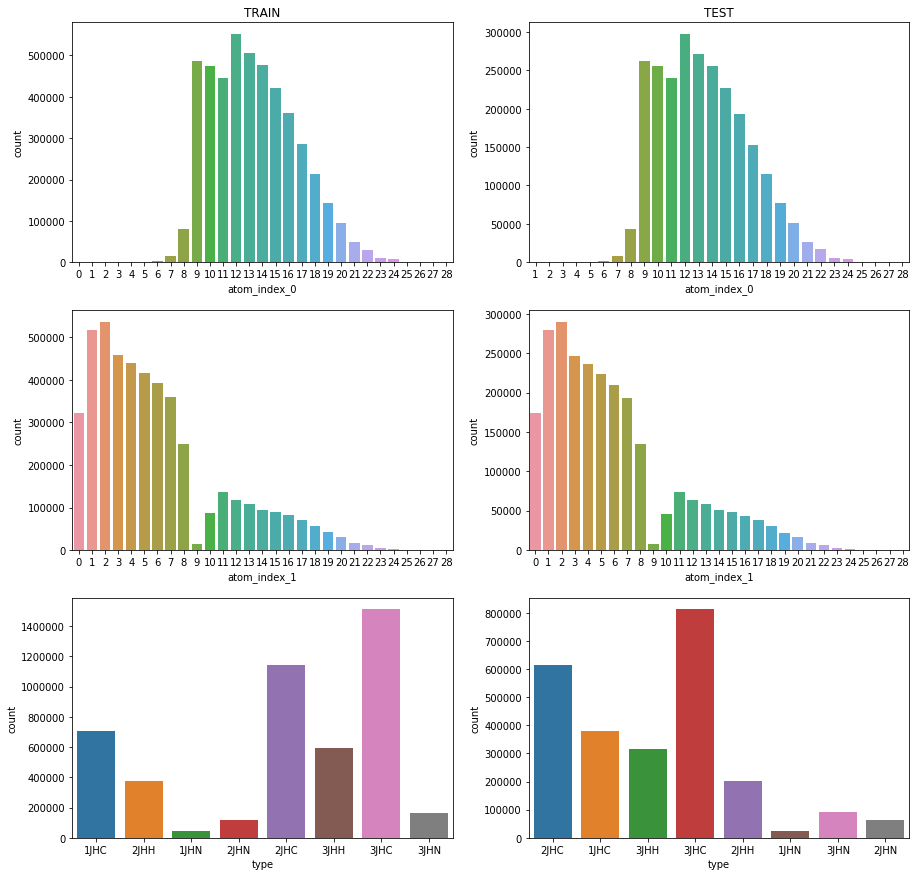

In [13]:
fig, ax = plt.subplots(3, 2, figsize=(15,15), facecolor='white')
sns.countplot(x='atom_index_0', data=train, ax=ax[0][0]).set_title('TRAIN')
sns.countplot(x='atom_index_1', data=train, ax=ax[1][0])
sns.countplot(x='type', data=train, ax=ax[2][0])
sns.countplot(x='atom_index_0', data=test, ax=ax[0][1]).set_title('TEST')
sns.countplot(x='atom_index_1', data=test, ax=ax[1][1])
sns.countplot(x='type', data=test, ax=ax[2][1])
fig.show();

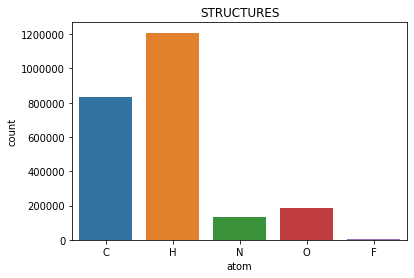

In [14]:
fig, ax = plt.subplots(facecolor='white')
sns.countplot(x='atom', data=structures).set_title("STRUCTURES")
plt.show();

## 1.4 Merging Data

Since train and scalar_coupling_contributions have the exact same `molecule_name`, `atom_index_0`, and `atom_index_1` columns, we could combine them directly. Also, it seems `dipole_moments` and `potential_energy` are just records of each `molecule_name`, we can merge them onto train as well.

`molecule_name` in `train`, `dipole_moments`, `magnetic_shielding_tensors`, `potential_energy`, and `scalar_coupling_contributions` were not included in `test`. How to amend the data?

Before we have an answer to ther question, lets just merge `structures` with `train` first.

In [54]:
show_ram_usage()

RAM usage: 7.200031280517578 GB


In [55]:
# Merging structures, potential_energy, dipole_moments, scalar_coupling_contributions
# not merging magnetic_shielding_tensor, would need to use structure merging tricks
X = merge_train_structures(train, structures).sort_values(by='id')
X = X.merge(potential_energy, on='molecule_name')
X = X.merge(dipole_moments, on='molecule_name')
X = pd.merge(X, scalar_coupling_contributions)
X = reduce_mem_usage(X)
assert X.shape[0] == train.shape[0]

Mem. usage decreased to 337.62 Mb (58.7% reduction)


In [57]:
X.head()

,id,molecule_name,atom_index_0,atom_index_1,type,scalar_coupling_constant,atom_0,x_0,y_0,z_0,...,y_1,z_1,potential_energy,X,Y,Z,fc,sd,pso,dso
0,0,dsgdb9nsd_000001,1,0,1JHC,84.812500,H,0.002150,-0.006031,0.001976,...,1.085938,0.008003,-40.53125,0.0,0.0,0.0,83.00000,0.254639,1.258789,0.271973
1,1,dsgdb9nsd_000001,1,2,2JHH,-11.257812,H,0.002150,-0.006031,0.001976,...,1.463867,0.000277,-40.53125,0.0,0.0,0.0,-11.03125,0.353027,2.857422,-3.433594
2,2,dsgdb9nsd_000001,1,3,2JHH,-11.257812,H,0.002150,-0.006031,0.001976,...,1.447266,-0.876465,-40.53125,0.0,0.0,0.0,-11.03125,0.353027,2.859375,-3.433594
3,3,dsgdb9nsd_000001,1,4,2JHH,-11.257812,H,0.002150,-0.006031,0.001976,...,1.437500,0.906250,-40.53125,0.0,0.0,0.0,-11.03125,0.353027,2.859375,-3.433594
4,4,dsgdb9nsd_000001,2,0,1JHC,84.812500,H,1.011719,1.463867,0.000277,...,1.085938,0.008003,-40.53125,0.0,0.0,0.0,83.00000,0.254639,1.258789,0.271973


# 1.5 Feature Importance

In [60]:
y = X.scalar_coupling_constant
X = X.drop(['scalar_coupling_constant', 'molecule_name', 'id', 'atom_0', 'atom_1'], axis=1)

In [61]:
show_ram_usage()

RAM usage: 7.426288604736328 GB


In [63]:
xgb = XGBRegressor(nthreads=-1)
encoder = ce.OrdinalEncoder()
pipe = Pipeline(steps=[('encoder', encoder),
                       ('xgb', xgb)])

In [64]:
%time pipe.fit(X, y)

c:\users\han-chung lee\.virtualenvs\ds5-kaggle-scalar-coupling-hywppjel\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
c:\users\han-chung lee\.virtualenvs\ds5-kaggle-scalar-coupling-hywppjel\lib\site-packages\xgboost\core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


[22:45:44] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[22:45:44] WARNING: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\learner.cc:686: Tree method is automatically selected to be 'approx' for faster speed. To use old behavior (exact greedy algorithm on single machine), set tree_method to 'exact'.
Wall time: 38min 5s


Pipeline(memory=None,
         steps=[('encoder',
                 OrdinalEncoder(cols=['type'], drop_invariant=False,
                                handle_missing='value', handle_unknown='value',
                                mapping=[{'col': 'type',
                                          'data_type': dtype('O'),
                                          'mapping': 1JHC    1
2JHH    2
1JHN    3
2JHN    4
2JHC    5
3JHH    6
3JHC    7
3JHN    8
NaN    -2
dtype: int64}],
                                return_df=True, verbose=0)),
                ('xgb',
                 XGBRegressor(base_score=0.5, booster='gbtree',
                              colsample_bylevel=1, colsample_bynode=1,
                              colsample_bytree=1, gamma=0,
                              importance_type='gain', learning_rate=0.1,
                              max_delta_step=0, max_depth=3, min_child_weight=1,
                              missing=None, n_estimators=100, n_jobs=1,
             

In [65]:
model = pipe.named_steps['xgb']

In [69]:
X.columns

Index(['atom_index_0', 'atom_index_1', 'type', 'x_0', 'y_0', 'z_0', 'x_1',
       'y_1', 'z_1', 'potential_energy', 'X', 'Y', 'Z', 'fc', 'sd', 'pso',
       'dso'],
      dtype='object')

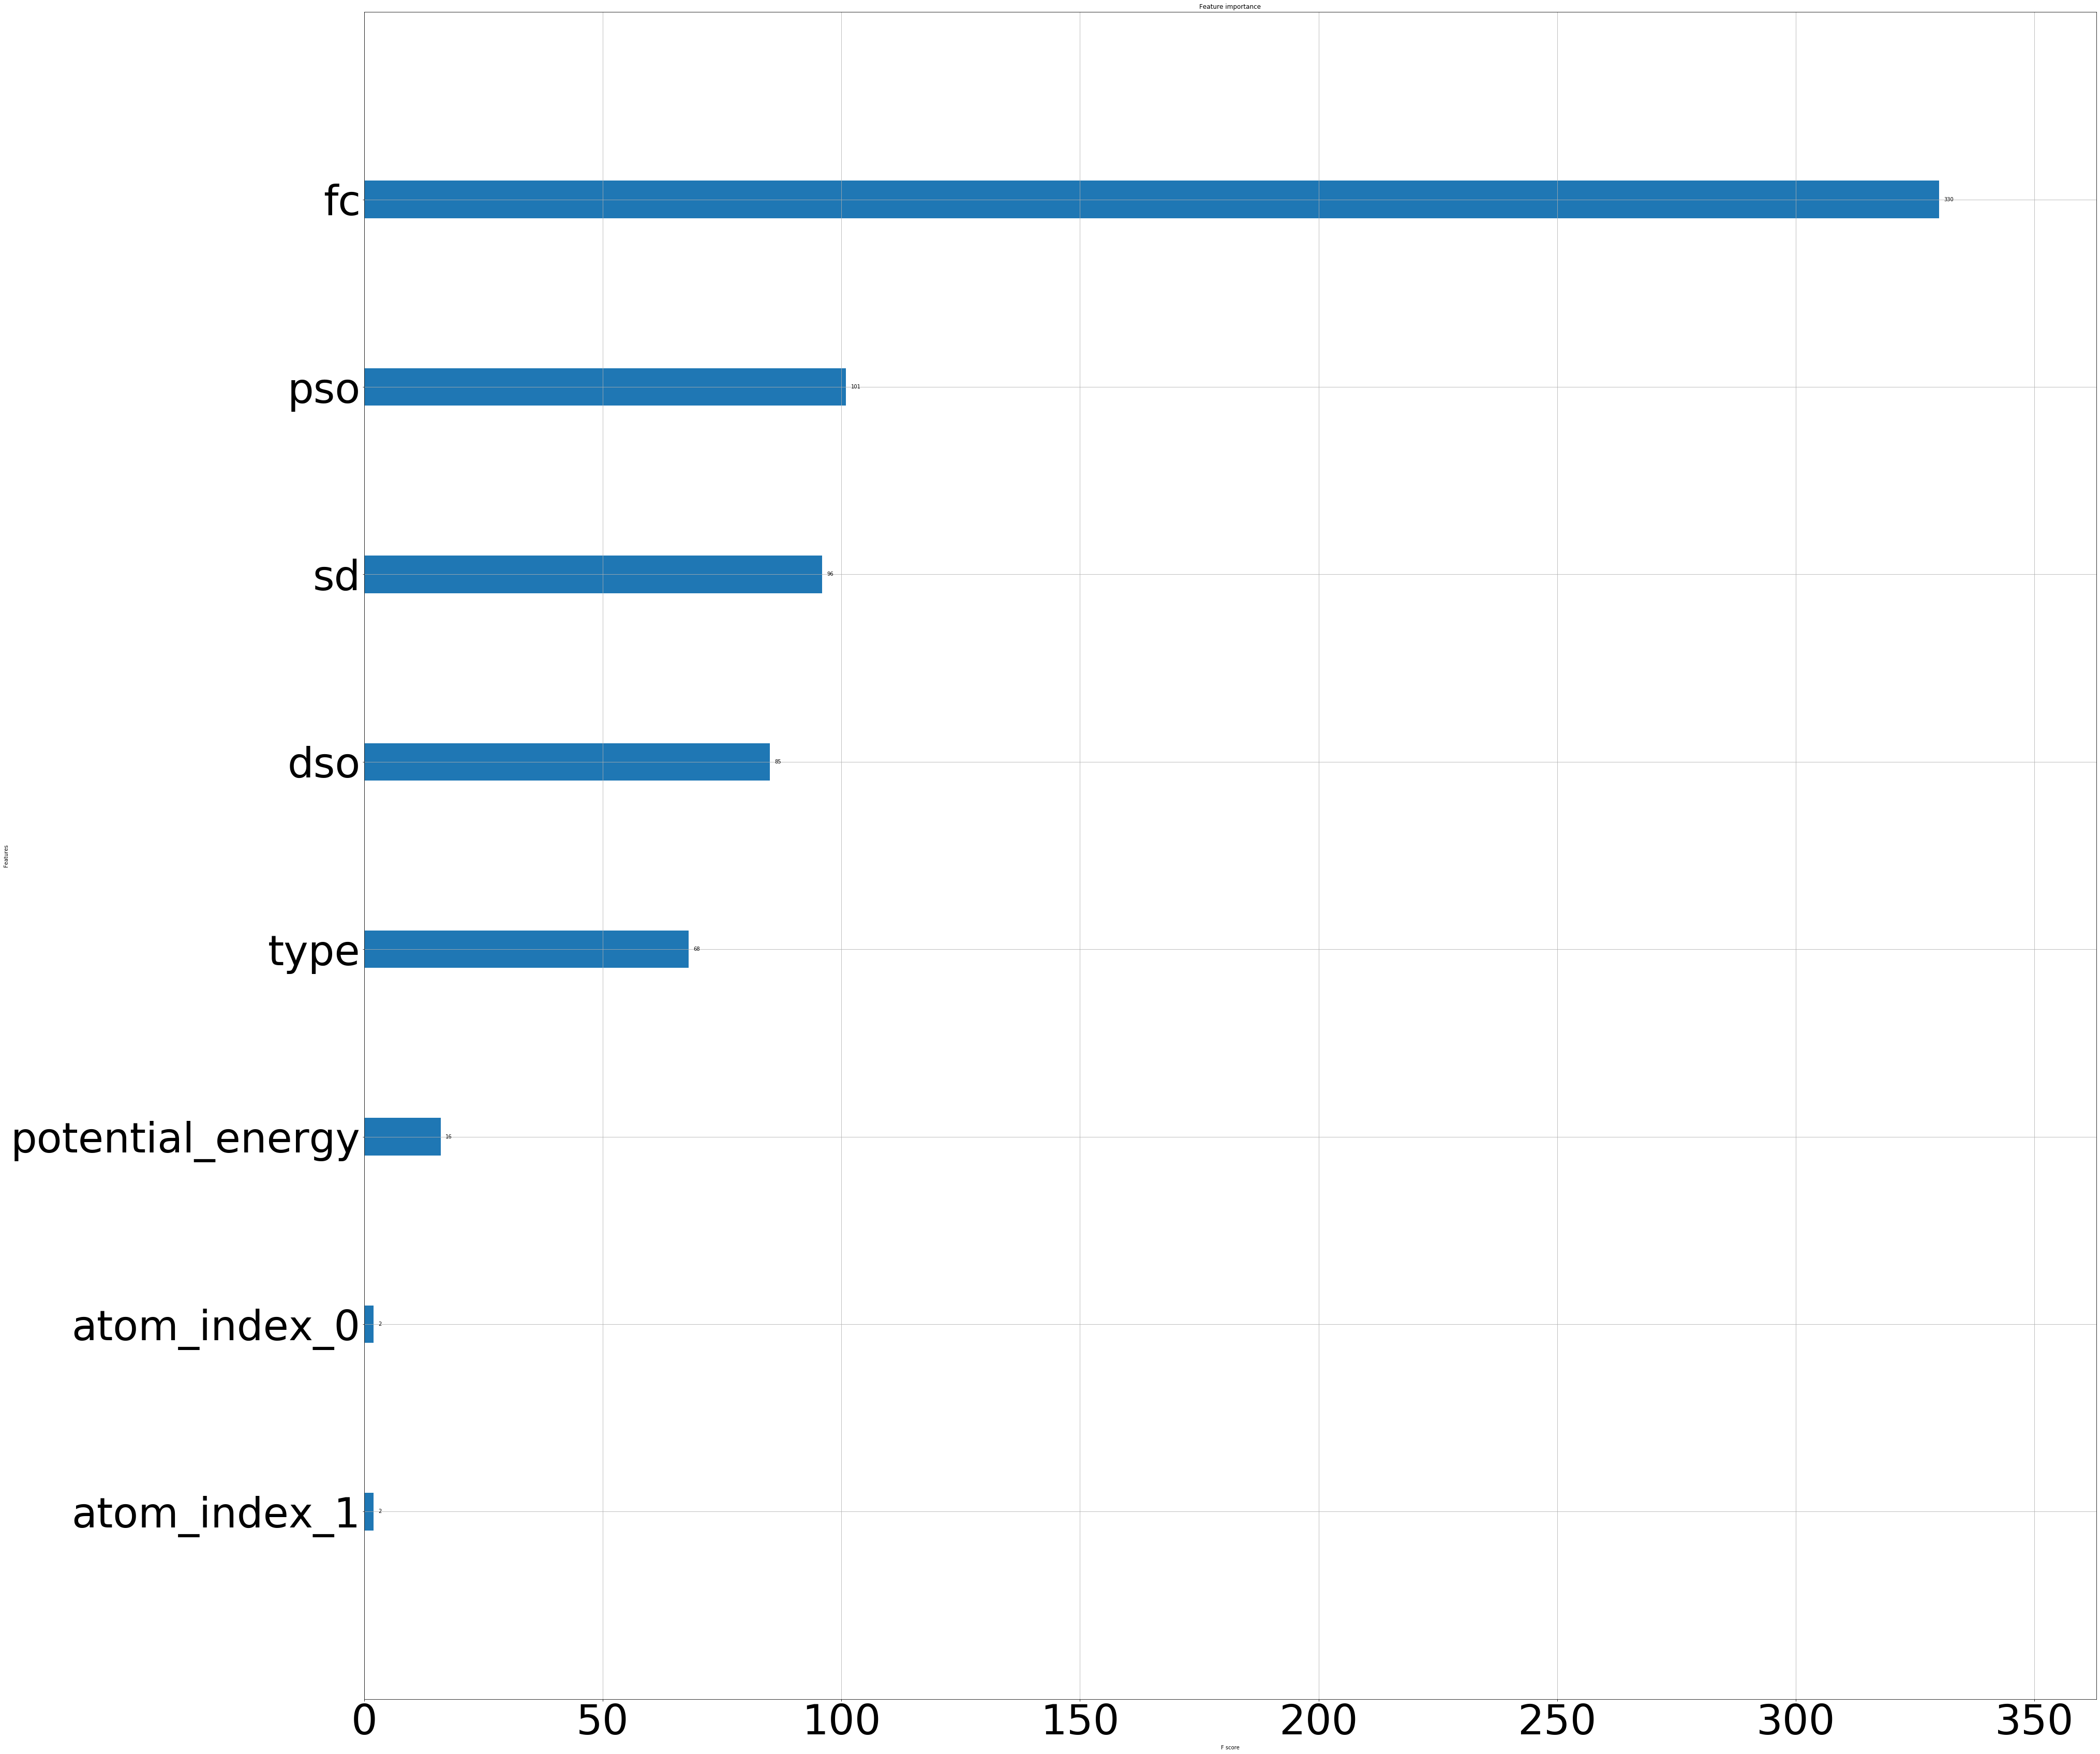

In [68]:
fig, ax = plt.subplots(figsize=(60, 60), facecolor='white')
ax.tick_params(axis='both', which='major', labelsize=80)
plot_importance(model, ax=ax)
# save fig, dont display. otherwise jupyternote size explodes
#fig.savefig("feature_importance.png")
plt.show();

In [73]:
y_pred = pipe.predict(X)

In [80]:
groups = train['type']
print(y.shape[0], X.shape[0])
%time group_mean_log_mae(y, y_pred, groups, floor=1e-9)

4658147 4658147
Wall time: 337 ms


-0.822336092729217